In [1]:
from keratin.metrics import dice, dice_loss
import numpy as np
from keratin.networks import unet
from keras.optimizers import Adam
from skimage.transform import resize
import keras
import matplotlib.pyplot as plt
import numpy as np
#%pylab inline

Using TensorFlow backend.
Failed to import duecredit due to No module named 'duecredit'


In [2]:
model = unet(256,256,n_channels=2)

/home/keshavan/software/keratin/keratin/networks.py:89: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  return km.Model(input=inputs, outputs=outputs)


In [3]:
model.compile(optimizer=Adam(lr=10e-5), 
              loss=dice_loss, 
              metrics=[dice])

In [4]:
from glob import glob

In [5]:
images = sorted(glob("../tiles/*/base*.jpg"))
hints = sorted(glob("../tiles/*/agg*.png"))
masks =sorted(glob("../tiles/*/truth*.png"))

def make256(images, hints = None):
    
    if not hints:
        bigM = np.zeros((len(images), 256, 256, 1))
    else:
        bigM = np.zeros((len(images), 256, 256, 2))
    
    for i, im in enumerate(images):

        data = plt.imread(im)
        if len(data.shape) == 3:
            do_mean = True
            data = (data[:,:,0]/255).astype(np.float32)
            if hints:
                hint = plt.imread(hints[i]).astype(np.float32)
            
        else:
            do_mean = False
            #print("mean_data", np.mean(data))
            data = (data/np.max(data)).astype(np.float32)
            #print("mean data", np.mean(data))

        if data.shape[0] > 256:
            data = data[:256, :]
        if data.shape[1] > 256:
            data = data[:, :256]

        data_pad = np.pad(data, (((256-data.shape[0])//2, ((256-data.shape[0]) + (data.shape[0]%2 >0))//2), 
                                 ((256-data.shape[1])//2, ((256-data.shape[1]) + (data.shape[1]%2 >0))//2)), 
                          "constant", constant_values = (0,0))
        
        if hints:
            
            if hint.shape[0] > 256:
                hint = hint[:256, :]
            if hint.shape[1] > 256:
                hint = hint[:, :256]
            
            hint_pad = np.pad(hint, (((256-hint.shape[0])//2, ((256-hint.shape[0]) + (hint.shape[0]%2 >0))//2), 
                         ((256-hint.shape[1])//2, ((256-hint.shape[1]) + (hint.shape[1]%2 >0))//2)), 
                  "constant", constant_values = (0,0))

        
        if do_mean:
            bigM[i,:,:,0] = (data_pad - np.mean(data_pad)) / np.std(data_pad)
            if hints:
                bigM[i,:,:,1] = (hint_pad - np.mean(hint_pad)) / np.std(hint_pad)
            
            #bigM_mean = np.mean(bigM)
            #bigM_std = np.std(bigM)
            #bigM = (bigM - bigM_mean)/bigM_std
        else:
            bigM[i,:,:,0] = data_pad
        
    return bigM

In [6]:
assert(len(images) == len(masks))

In [7]:
assert(len(hints) == len(masks))

In [8]:
images[0]

'../tiles/sub000/base002.jpg'

In [9]:
subjects_all = [i.split("/")[-2] for i in images]

In [10]:
subjects = np.asarray(sorted(list(set(subjects_all))))

In [11]:
subjects

array(['sub000', 'sub001', 'sub002', 'sub003', 'sub005', 'sub006',
       'sub007', 'sub008', 'sub010', 'sub011', 'sub013', 'sub014',
       'sub015', 'sub017', 'sub020', 'sub021', 'sub022', 'sub023',
       'sub025', 'sub026', 'sub029', 'sub030', 'sub031'],
      dtype='<U6')

In [12]:
bigM_base = make256(images, hints)
bigM_base.shape

(188, 256, 256, 2)

In [13]:
#masks = glob("../tiles/s*/truth*.png")
bigM_mask = make256(masks)
bigM_mask.shape

(188, 256, 256, 1)

In [14]:
bigM_mask[0,:,:,0].any()

True

In [15]:
idx = list(range(len(set(subjects))))
np.random.shuffle(idx)

In [16]:
subjects[idx]

array(['sub001', 'sub003', 'sub022', 'sub005', 'sub020', 'sub015',
       'sub029', 'sub017', 'sub025', 'sub014', 'sub031', 'sub008',
       'sub011', 'sub006', 'sub007', 'sub013', 'sub010', 'sub026',
       'sub021', 'sub030', 'sub002', 'sub000', 'sub023'],
      dtype='<U6')

In [17]:
len(subjects)

23

In [18]:
train_subs = idx[:int(0.8*subjects.shape[0])]
test_subs = idx[int(0.8*subjects.shape[0]):int(0.9*subjects.shape[0])]
val_subs = idx[int(0.9*subjects.shape[0]):]

In [19]:
subjects[train_subs]

array(['sub001', 'sub003', 'sub022', 'sub005', 'sub020', 'sub015',
       'sub029', 'sub017', 'sub025', 'sub014', 'sub031', 'sub008',
       'sub011', 'sub006', 'sub007', 'sub013', 'sub010', 'sub026'],
      dtype='<U6')

In [20]:
subjects[test_subs]

array(['sub021', 'sub030'],
      dtype='<U6')

In [21]:
subjects[val_subs]

array(['sub002', 'sub000', 'sub023'],
      dtype='<U6')

In [22]:
train = [i for i, val in enumerate(subjects_all) if val in subjects[train_subs]]
np.random.shuffle(train)
test = [i for i, val in enumerate(subjects_all) if val in subjects[test_subs]]
np.random.shuffle(test)
val = [i for i, val in enumerate(subjects_all) if val in subjects[val_subs]]
np.random.shuffle(val)

In [23]:
#back when i didn't split by subject

#train = idx[:int(0.8*bigM_base.shape[0])]
#test = idx[int(0.8*bigM_base.shape[0]):int(0.9*bigM_base.shape[0])]
#val = idx[int(0.9*bigM_base.shape[0]):]

In [24]:
x_train = bigM_base[train, :]
y_train = bigM_mask[train, :]

x_test = bigM_base[test, :]
y_test = bigM_mask[test, :]

x_val = bigM_base[val, :]
y_val = bigM_mask[val, :]


In [25]:
x_train.shape

(149, 256, 256, 2)

**AK:** `killall python` to free up GPU memory (you only have 3.9GB)

`nvidia smi` to monitor usage

apparently this uses 3.4GB already

#### Data Augmentation

In [26]:
from skimage.transform import AffineTransform, matrix_transform, warp

In [27]:
def get_random_affine():
    rotation = np.random.rand()*np.pi/45/2 * (np.random.binomial(1,0.5) * 2 - 1) # +- 4 degrees
    shear = np.random.rand()*np.pi/45/2 * (np.random.binomial(1,0.5) * 2 - 1) # +- 4 degrees
    translation = [t * (np.random.binomial(1,0.5) * 2 - 1) for t in np.random.rand(2) * 10] 
    scale = [1 + (t * (np.random.binomial(1,0.5) * 2 - 1)) for t in (np.random.rand(2) / 10)] 
    #print("r", rotation, "s", shear, "t", translation, "sc", scale)
    return AffineTransform(scale=scale, rotation=rotation, shear=shear, translation=translation)

In [28]:
def wiggle_image(data, truth):
    xfm = get_random_affine()
    return warp(data, xfm), warp(truth, xfm)

In [29]:
def get_new_log_dir():
    current_logs = sorted(glob("./log_try_????"))
    if len(current_logs) == 0:
        return "./log_try_0000"
    else:
        max_num = int(current_logs[-1].split("_")[-1])
        return "./log_try_%04d" % (max_num + 1)
    
def get_new_checkpoint_dir():
    current_logs = sorted(glob("./checkpoint_try_????"))
    if len(current_logs) == 0:
        return "./checkpoint_try_0000"
    else:
        max_num = int(current_logs[-1].split("_")[-1])
        return "./checkpoint_try_%04d" % (max_num + 1)

In [30]:
aug_num = 4 #16 = 2^4 times

x_train_aug = x_train.copy()
y_train_aug = y_train.copy()

x_val_aug = x_val.copy()
y_val_aug = y_val.copy()

def augment_data(x_arr, y_arr):
    X = np.zeros(x_arr.shape)
    Y = np.zeros(y_arr.shape)
    for idx, img in enumerate(x_arr):
        y_img = y_arr[idx,:,:,:]
        new_x, new_y = wiggle_image(img, y_img)
        X[idx, :,:,:] = new_x
        Y[idx,:,:,:] = new_y
    #print(X.shape, Y.shape)
    x_arr = np.vstack((x_arr, X))
    y_arr = np.vstack((y_arr, Y))
    #print(x_arr.shape, y_arr.shape)
    return x_arr, y_arr

for i in range(aug_num):
    x_train_aug, y_train_aug = augment_data(x_train_aug, y_train_aug)
    x_val_aug, y_val_aug = augment_data(x_val_aug, y_val_aug)
    print(x_train_aug.shape, x_val_aug.shape)
    #break



(298, 256, 256, 2) (62, 256, 256, 2)
(596, 256, 256, 2) (124, 256, 256, 2)
(1192, 256, 256, 2) (248, 256, 256, 2)
(2384, 256, 256, 2) (496, 256, 256, 2)


### Remove some hints

**AK**: it wasn't happy with this

### Weaken some hints

In [31]:
count = 0
for i in range(x_train_aug.shape[0]):
    if np.random.binomial(1,0.3):
        count +=1
        hint = x_train_aug[i,:,:,1]
        x_train_aug[i,:,:,1], _ = wiggle_image(hint, hint)
        
print(count/x_train_aug.shape[0]*100, "% wiggled hints")

count = 0
for i in range(x_val_aug.shape[0]):
    if np.random.binomial(1,0.3):
        count +=1
        hint = x_val_aug[i,:,:,1]
        x_val_aug[i,:,:,1], _ = wiggle_image(hint, hint)
        
print(count/x_val_aug.shape[0]*100, "% wiggled hints")


31.837248322147648 % wiggled hints
31.85483870967742 % wiggled hints


### Dilate and Erode some hints

In [32]:
from skimage.morphology import dilation, erosion
from skimage.morphology import disk

def dilate_or_erode_image(img, do_dilate):
    if do_dilate:
        return dilation(img, disk(3))
    else:
        return erosion(img, disk(3))

In [33]:
count = 0
for i in range(x_train_aug.shape[0]):
    if np.random.binomial(1,0.3):
        count +=1
        hint = x_train_aug[i,:,:,1]
        x_train_aug[i,:,:,1] = dilate_or_erode_image(hint, np.random.binomial(1,0.5))
        
print(count/x_train_aug.shape[0]*100, "% dilated or eroded hints")

count = 0
for i in range(x_val_aug.shape[0]):
    if np.random.binomial(1,0.3):
        count +=1
        hint = x_val_aug[i,:,:,1]
        x_val_aug[i,:,:,1] = dilate_or_erode_image(hint, np.random.binomial(1,0.5))
        
print(count/x_val_aug.shape[0]*100, "% dilated or eroded hints")


30.411073825503355 % dilated or eroded hints
29.838709677419356 % dilated or eroded hints


In [34]:
model.fit(x_train_aug, y_train_aug, batch_size=4, 
          epochs=10, verbose=1, validation_data=(x_val_aug, y_val_aug), 
          callbacks=[keras.callbacks.TensorBoard(log_dir=get_new_log_dir(), histogram_freq=0, 
                                                 batch_size=4, write_graph=True, 
                                                 write_grads=True, write_images=True, 
                                                 embeddings_freq=0, embeddings_layer_names=None, 
                                                 embeddings_metadata=None),
                     keras.callbacks.ModelCheckpoint(get_new_checkpoint_dir(), monitor='val_dice', 
                                                     verbose=0, save_best_only=False, save_weights_only=False, 
                                                     mode='auto', period=1)
                    ]
)

Train on 2384 samples, validate on 496 samples
Epoch 1/10
2384/2384 [==============================] - 184s - loss: -0.7144 - dice: 0.7144 - val_loss: -0.8328 - val_dice: 0.8328
Epoch 2/10
2384/2384 [==============================] - 180s - loss: -0.8153 - dice: 0.8153 - val_loss: -0.8612 - val_dice: 0.8612
Epoch 3/10
2384/2384 [==============================] - 179s - loss: -0.8448 - dice: 0.8448 - val_loss: -0.9042 - val_dice: 0.9042
Epoch 4/10
2384/2384 [==============================] - 179s - loss: -0.8555 - dice: 0.8555 - val_loss: -0.9029 - val_dice: 0.9029
Epoch 5/10
2384/2384 [==============================] - 179s - loss: -0.8782 - dice: 0.8782 - val_loss: -0.9096 - val_dice: 0.9096
Epoch 6/10
2384/2384 [==============================] - 179s - loss: -0.8984 - dice: 0.8984 - val_loss: -0.9241 - val_dice: 0.9241
Epoch 7/10
2384/2384 [==============================] - 179s - loss: -0.9130 - dice: 0.9130 - val_loss: -0.9134 - val_dice: 0.9134
Epoch 8/10
2384/2384 [==============

In [35]:
score = model.evaluate(x_test, y_test)
score

8/8 [==============================] - 1s


[-0.70126605033874512, 0.70126605033874512]

In [36]:
x_test_no_hint = x_test.copy()
x_test_no_hint[:,:,:,1] = 0

In [37]:
score_no_hint = model.evaluate(x_test_no_hint, y_test)
score_no_hint

8/8 [==============================] - 0s


[-0.10706168413162231, 0.10706168413162231]

In [38]:
x_test_no_brain = x_test.copy()
x_test_no_brain[:,:,:,0] = 0
score_no_brain = model.evaluate(x_test_no_brain, y_test)
score_no_brain

8/8 [==============================] - 0s


[-0.0017123015131801367, 0.0017123015131801367]

In [37]:
y_pred = model.predict(x_test)
y_pred_no_hint = model.predict(x_test_no_hint)
y_pred_no_brain = model.predict(x_test_no_brain)

In [38]:
assert(y_pred.shape==y_test.shape)

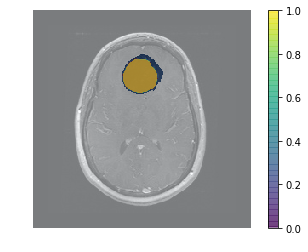

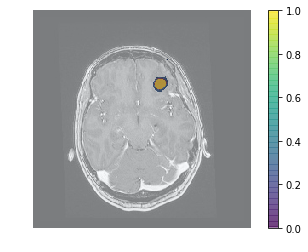

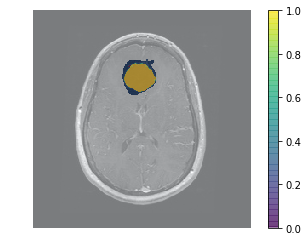

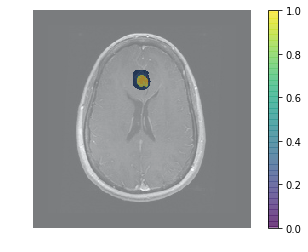

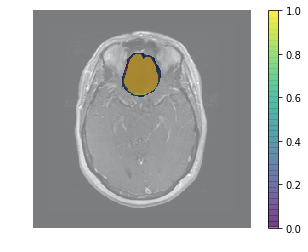

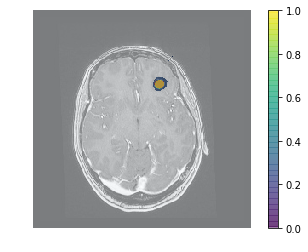

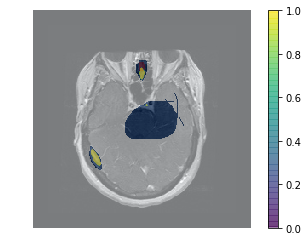

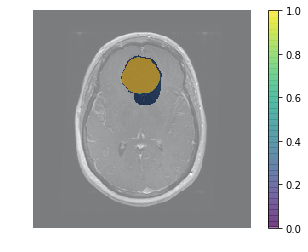

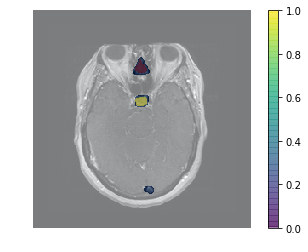

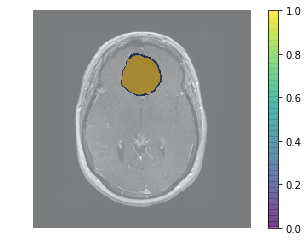

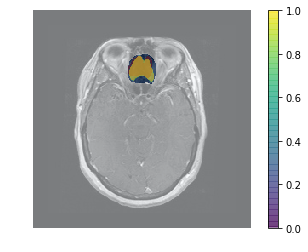

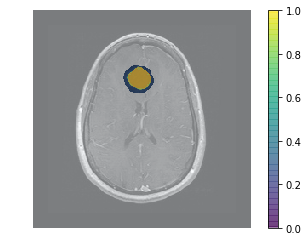

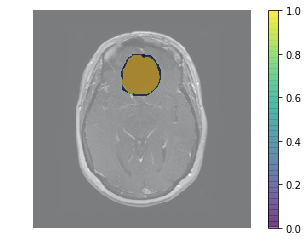

In [39]:
%matplotlib inline
for i in range(x_test.shape[0]):
    plt.figure(i)
    plt.imshow(x_test[i,:,:,0].reshape(256,256), cmap=plt.cm.Greys_r)
    
    hint = x_test[i,:,:,1].reshape(256,256)
    hint[hint==0] = np.nan
    plt.imshow(hint, cmap=plt.cm.Blues, vmin=0, vmax=1, alpha=0.5)
    
    truth = y_test[i,:,:,0].reshape(256,256)
    truth[truth==0] = np.nan
    plt.imshow(truth, cmap=plt.cm.Reds, vmin=0, vmax=1, alpha=0.5)
    
    roi = y_pred[i,:,:,0].reshape(256,256)
    roi[roi<0.5] = np.nan
    plt.imshow(roi, alpha=0.5, vmin=0, vmax=1)
    plt.axis("off")
    plt.colorbar()

In [45]:
len(subjects)

23

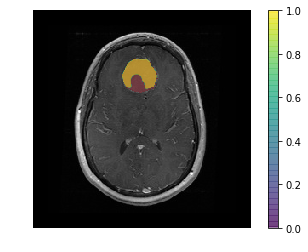

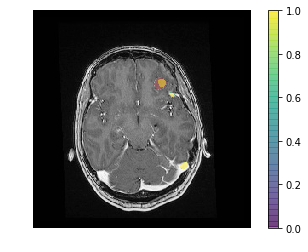

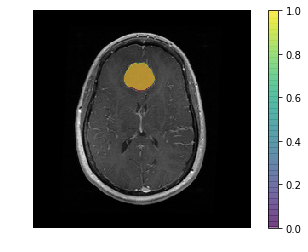

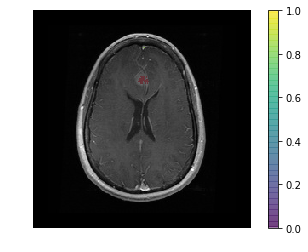

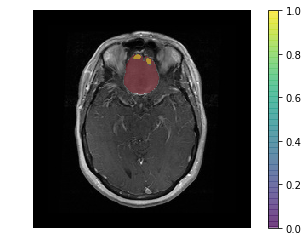

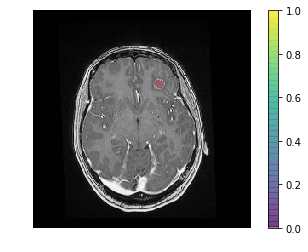

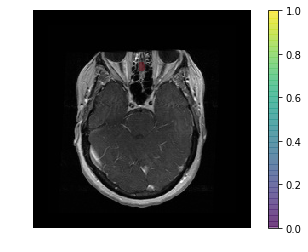

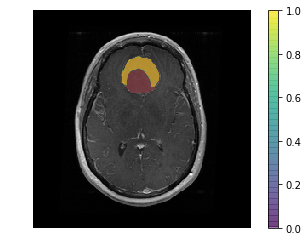

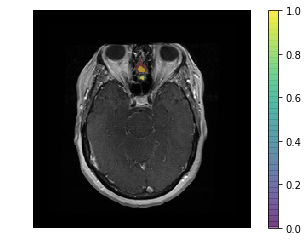

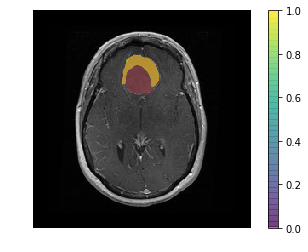

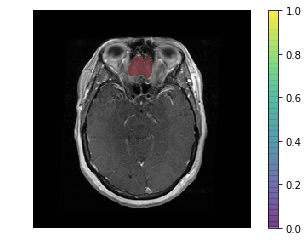

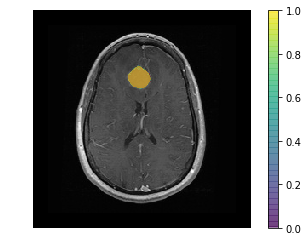

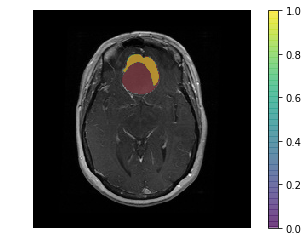

In [40]:
for i in range(x_test.shape[0]):
    plt.figure(i)
    plt.imshow(x_test[i,:,:,0].reshape(256,256), cmap=plt.cm.Greys_r)
    
    #hint = x_test[i,:,:,1].reshape(256,256)
    #hint[hint==0] = np.nan
    #plt.imshow(hint, cmap=plt.cm.Blues, vmin=0, vmax=1, alpha=0.5)
    
    truth = y_test[i,:,:,0].reshape(256,256)
    truth[truth==0] = np.nan
    plt.imshow(truth, cmap=plt.cm.Reds, vmin=0, vmax=1, alpha=0.5)
    
    roi = y_pred_no_hint[i,:,:,0].reshape(256,256)
    roi[roi<0.5] = np.nan
    plt.imshow(roi, alpha=0.5, vmin=0, vmax=1)
    plt.axis("off")
    plt.colorbar()

# run tensorboard

```bash
tensorboard --log ./logs
```

## TODOS:

* standardization
* add "hint" channel but smooth first
* bug satra to give more data